In [35]:
import re
import os
import ast
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, accuracy_score, classification_report, make_scorer, fbeta_score

### Strategy

--First of all we'll do some feature engineering in order to generate features to feed to our model. This will involve steps like binning ages of people (eg. 30-40, 40-50, etc.), converting the time to datetime object in order to extract the year and month and so on<br>

--After this, a RandomForestClassifier will be used as the machine learning model as it gives very good results without much tweaking

--The metrics used for model evaluation are discussed below

In [36]:
profile = pd.read_csv('resources/profile.csv', parse_dates=[3])
portfolio = pd.read_csv('resources/portfolio.csv')
transcript = pd.read_csv('resources/transcript.csv')

In [37]:
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

portfolio['web'], portfolio['email'], portfolio['mobile'], portfolio['social'] = 0, 0, 0, 0
portfolio.drop('channels', axis=1, inplace=True)

portfolio[['web', 'email', 'mobile', 'social']] = [[0, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 1], [1, 1, 0, 0], 
                                                   [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 0], [0, 1, 1, 1]]
portfolio

,reward,mms_unlock,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,1,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
3,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0
8,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
9,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,1,1,1


In [38]:
profile = pd.get_dummies(profile, columns=['gender'])

In [39]:
profile['joined'] = profile['became_member_on'].dt.year

profile = pd.get_dummies(profile, columns=['joined'])

# One hot encode a customer's age range
min_age_limit = np.int(np.floor(np.min(profile['age']) / 10) * 10)
max_age_limit = np.int(np.ceil(np.max(profile['age']) / 10) * 10)

# Put ages into bins
profile['age_range'] = pd.cut(profile['age'], (range(min_age_limit,max_age_limit + 10, 10)), right=False)
profile['age_range'] = profile['age_range'].astype('str')

agerange_df = pd.get_dummies(profile['age_range'])

In [40]:
profile = pd.concat([profile, agerange_df], axis=1)
profile.drop(['age', 'became_member_on', 'age_range'], axis=1, inplace=True)

In [41]:
profile.head()

,customer_id,income,gender_F,gender_M,gender_O,joined_2013,joined_2014,joined_2015,joined_2016,joined_2017,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [42]:
transcript['value'] = transcript['value'].apply(lambda x: ast.literal_eval(x))

In [43]:
def clean_transcript(profile, transcript):
    """ Transforms a DataFrame that contains records for profile and transactions

    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
        transcript: DataFrame containing all transactions

    OUTPUT:
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    """

    # Select customer offers
    pattern = re.compile('^offer (?:received|viewed|completed)')
    h_is_offer = lambda x: pattern.match(x) != None
    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Create an offer_id column
    offer_data['offer_id'] = offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern = re.compile('^offer ([a-z]+$)')
    
    h_transform = lambda x: pattern.match(x).groups(1)[0]
    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] = transaction['value'].apply(lambda elem: list(elem.values())[0])
    
    # Drop unncessary columns
    transaction.drop(['event', 'value'], axis=1, inplace=True)
    offer_data.drop(['event', 'value'], axis=1, inplace=True)

    return offer_data, transaction

In [44]:
offer_data, transaction = clean_transcript(profile, transcript)

In [45]:
offer_data.head()

,customer_id,days_since_test_start,offer_id,completed,received,viewed
0,0009655768c64bdeb2e877511632db8f,7.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0
1,0009655768c64bdeb2e877511632db8f,8.0,5a8bc65990b245e5a138643cd4eb9837,0,0,1
2,0009655768c64bdeb2e877511632db8f,14.0,3f207df678b143eea3cee63160fa8bed,0,1,0
3,0009655768c64bdeb2e877511632db8f,15.5,3f207df678b143eea3cee63160fa8bed,0,0,1
4,0009655768c64bdeb2e877511632db8f,17.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0


In [46]:
transaction.head()

,customer_id,days_since_test_start,amount
0,0009655768c64bdeb2e877511632db8f,9.50,22.16
1,0009655768c64bdeb2e877511632db8f,17.25,8.57
2,0009655768c64bdeb2e877511632db8f,22.00,14.11
3,0009655768c64bdeb2e877511632db8f,23.00,13.56
4,0009655768c64bdeb2e877511632db8f,24.00,10.27


In [47]:
def create_offeranalysis_dataset(profile, portfolio, offer_data, transaction):
    """ Creates a clean dataset from the 4 given datasets

    INPUT:
        profile: DataFrame that contains demographic data for each customer
        portfolio: Contains offer ids and metadata
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions

    OUTPUT:
        clean_data: DataFrame that characterizes the effectiveness of customer offers
    """
    
    clean_data = []
    customer_id_list = offer_data['customer_id'].unique()

    for idx in tqdm_notebook(range(len(customer_id_list))):
        clean_data.extend(create_combined_records(customer_id_list[idx], portfolio, profile, offer_data, transaction))

    clean_data = pd.DataFrame(clean_data)

    # DataFrame column ordering
    column_ordering = ['time', 'offer_id', 'customer_id', 'total_amount', 'offer_successful', 'mms_unlock', 
                       'duration', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'email', 
                       'mobile', 'social', 'web', 'gender_M', 'gender_F', 'gender_O', 'income', 'joined_2013', 
                       'joined_2014', 'joined_2015', 'joined_2016''joined_2017', 'joined_2018', '[10, 20)', '[20, 30)', 
                       '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)', '[100, 110)']

    clean_data = clean_data[column_ordering]

    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)

def create_combined_records(customer_id, portfolio, profile, offer_data, transaction):
    
    """ 
    Creates a list of dictionaries that describes the effectiveness of offers to a specific customer

    INPUT:
        customer_id: String that refers to a specific customer
        profile: DataFrame that contains demographic data for each 
                 customer         
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of offers to a specific customer
    """
    
    # Select a customer's profile
    cur_customer = profile[profile['customer_id'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customer_id'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customer_id')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction['customer_id'] == customer_id
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data = customer_transaction_data.drop(columns='customer_id')

    customer_transaction_data = customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['completed', 'received', 'viewed']

    offer_received = customer_offer_data[customer_offer_data['received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed = customer_offer_data[customer_offer_data['viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed = customer_offer_data[customer_offer_data['completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialise the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer_id']

        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offer_id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]

        # Initialise the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['days_since_test_start']

        cur_offer_endtime = offer_received.iloc[idx]['days_since_test_start'] + durationdays

        # Initialise a boolean array that select customer transcations that falls within the valid offer time window
        select_transaction = np.logical_and(customer_transaction_data['days_since_test_start'] >= cur_offer_startime,
                                            customer_transaction_data['days_since_test_start'] <= cur_offer_endtime)

        # Initialise a boolean array that selects a description of when a customer completes an offer
        select_offer_completed = np.logical_and(offer_completed['days_since_test_start'] >= cur_offer_startime,
                                                offer_completed['days_since_test_start'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a customer views an offer
        select_offer_viewed = np.logical_and(offer_viewed['days_since_test_start'] >= cur_offer_startime,
                                             offer_viewed['days_since_test_start'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialise a dictionary that describes the current customer offer
        cur_row = {'offer_id': cur_offer_id,
                   'customer_id': customer_id,
                   'time': cur_offer_startime,
                   'offer_successful': int(cur_offer_successful),
                   'total_amount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of offers to a specific customer
        rows.append(cur_row)

    return rows

In [48]:
clean_data_csvfile = 'resources/clean_data.csv'

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile, portfolio, offer_data, transaction)

clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time', 'customer_id', 'email', 'offer_type_informational'])

column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

,offer_id,total_amount,offer_successful,mms_unlock,duration,offer_type_bogo,offer_type_discount,web,mobile,social,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,5a8bc65990b245e5a138643cd4eb9837,22.16,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
1,3f207df678b143eea3cee63160fa8bed,8.57,1,0,4,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,f19421c1d4aa40978ebb69ca19b0e20d,22.68,1,5,5,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3,fafdcd668e3743c1bb461111dcafc2a4,96.87,1,10,10,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,2906b810c7d4411798c6938adc9daaa5,69.20,0,10,7,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0


In [49]:
class_label_name = 'offer_successful'

variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

X_train, X_test, y_train, y_test = train_test_split(variables.values, class_label.values, test_size=0.2, random_state=69)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [50]:
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid,
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=['mms_unlock', 'offer_type_bogo', 'offer_type_discount', 'mobile', 'social', 'web'])

training_data.head()

,offerid,duration,income,gender_F,gender_M,gender_O,joined_2013,joined_2014,joined_2015,joined_2016,...,"[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)",offer_successful
0,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,97000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,f19421c1d4aa40978ebb69ca19b0e20d,5.0,47000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,f19421c1d4aa40978ebb69ca19b0e20d,5.0,60000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,ae264e3637204a6fb9bb56bc8210ddfd,7.0,75000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,32000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### RandomForestClassifier

Bias and variance are two characteristics of a machine learning model. Bias refers to inherent model assumptions regarding the decision boundary between different classes. On the other hand, variance refers a model's sensitivity to changes in its inputs. A logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers. However, my exploratory analysis of customer demographics for each offer suggests that this decision boundary will be non-linear. Therefore, an ensemble method like random forest or gradient boosting should perform better.

A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using majority voting. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples.

In [51]:
clf = RandomForestClassifier(random_state=69, n_jobs=-1)

# Create the param grid
params = {'n_estimators': [150, 200, 300],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [i for i in range(7, 13)]}

gr_cv = GridSearchCV(clf, params, make_scorer(fbeta_score, beta=2), -1, cv=3, verbose=3, return_train_score=True)

# Fit the model
gr_cv.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=69,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_

### Analysis of GridSearchCV (Refinement)

In [56]:
# Dataframe for our cross-validation results
results = pd.DataFrame(gr_cv.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.572999,0.682287,4.025425,0.250401,7,auto,150,"{'max_depth': 7, 'max_features': 'auto', 'n_es...",0.751117,0.740038,0.762761,0.751305,0.009278,5,0.759351,0.753118,0.761155,0.757874,0.003443
1,8.034584,0.291827,1.539765,0.156708,7,auto,200,"{'max_depth': 7, 'max_features': 'auto', 'n_es...",0.750728,0.739795,0.763543,0.751355,0.009705,3,0.758449,0.752829,0.762582,0.757953,0.003997
2,9.157329,0.689518,1.014851,0.685198,7,auto,300,"{'max_depth': 7, 'max_features': 'auto', 'n_es...",0.751797,0.740142,0.763241,0.751726,0.009430,1,0.759481,0.753133,0.762462,0.758359,0.003890
3,4.959452,1.010558,3.397800,0.403440,7,sqrt,150,"{'max_depth': 7, 'max_features': 'sqrt', 'n_es...",0.751117,0.740038,0.762761,0.751305,0.009278,5,0.759351,0.753118,0.761155,0.757874,0.003443
4,8.284241,0.248246,1.051149,0.155372,7,sqrt,200,"{'max_depth': 7, 'max_features': 'sqrt', 'n_es...",0.750728,0.739795,0.763543,0.751355,0.009705,3,0.758449,0.752829,0.762582,0.757953,0.003997


In [58]:
results.iloc[:, 8:].head()

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.751117,0.740038,0.762761,0.751305,0.009278,5,0.759351,0.753118,0.761155,0.757874,0.003443
1,0.750728,0.739795,0.763543,0.751355,0.009705,3,0.758449,0.752829,0.762582,0.757953,0.003997
2,0.751797,0.740142,0.763241,0.751726,0.009430,1,0.759481,0.753133,0.762462,0.758359,0.003890
3,0.751117,0.740038,0.762761,0.751305,0.009278,5,0.759351,0.753118,0.761155,0.757874,0.003443
4,0.750728,0.739795,0.763543,0.751355,0.009705,3,0.758449,0.752829,0.762582,0.757953,0.003997


We have quite a consistent f1-score across all folds, therefore our model is quite robust and can be safely used to provide offers and offers to Starbuck's customers!

In [53]:
gr_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

--We can also see that 'max_depth' leads to overfitting for higher values, so a value of 7 is the perfect sweet spot.<br>
--However, 'n_estimators' tend to be on the higher side at 300 (anything less lead to underfitting)<br>
--Finally, 'max_fearures' was set to 'auto', i.e., max_features=sqrt(n_features)

### Why use F1-score?

F1 Score is needed when you want to seek a balance between Precision and Recall. Accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible). Thus [F1 Score](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives).

For instance, in fraud detection or sick patient detection. If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.

In [59]:
y_pred = gr_cv.predict(X_test)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('F1 score: {}'.format(round(f1, 2)))
print('Accuracy score: {}'.format(round(acc, 2)))

F1 score: 0.73
Accuracy score: 0.73


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      7069
           1       0.68      0.78      0.73      6232

    accuracy                           0.73     13301
   macro avg       0.73      0.73      0.73     13301
weighted avg       0.73      0.73      0.73     13301



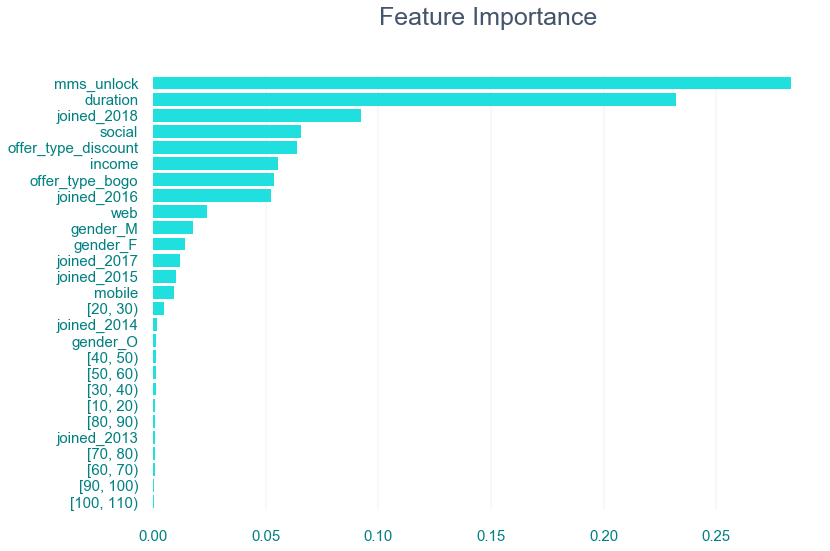

In [61]:
imp = gr_cv.best_estimator_.feature_importances_
features = variable_names
df_feat = pd.DataFrame({'Imp': imp, 'Features': features}).sort_values('Imp', ascending=False)

plt.style.use('seaborn-whitegrid')
fix, ax = plt.subplots(figsize=(12, 8))

ax.set_title('Feature Importance', color='#44546B', pad=50, fontsize=25)

ax.tick_params('x', colors='#008080', labelsize=15, pad=20)
ax.tick_params('y', colors='#008080', labelsize=15, pad=15)

for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set_visible(False)

ax.grid(axis='x', color='gray', linewidth=0.1)

sns.barplot('Imp', 'Features', data=df_feat, color='cyan')

plt.ylabel('');
plt.xlabel('');

### Reflection
The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem had three steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of the model. Fourth, I refined random forest model hyperparameters using a grid search. My analysis suggests that the resulting random forest model has an training data accuracy of 0.73 and an F1-score of 0.73. This suggests that the random forest model I constructed did not overfit to the training data.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. My analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top five features based on their importance are:

1. Offer difficulty (how much money a customer must spend to complete an offer)  
2. Offer duration   
3. Whether a customer created an account on the Starbucks rewards mobile application in 2018
4. Customer income  

Since the top three features are associated with an customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.

I'm quite optimistic that this entire project will help Starbucks to improve their offers and discount in order to increase revenue and customer satisfaction!